In [2]:
import torch
from torch_geometric.data import DataLoader
from model import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import yaml
from easydict import EasyDict
import os
from statistics import mean, stdev


In [2]:
filenames = [f for f in os.listdir("exp") if not f.startswith('.')] 

In [3]:
filenames.sort()

In [4]:
filenames

['asap_1_16_0',
 'asap_1_1_0',
 'asap_1_4_0',
 'asap_1_8_0',
 'avg_1_16_0',
 'avg_1_1_0',
 'avg_1_4_0',
 'avg_1_8_0',
 'avg_2_16_0',
 'avg_2_1_0',
 'avg_2_4_0',
 'avg_2_8_0',
 'avg_4_16_0']

In [5]:
config_file = os.path.join('exp',filenames[1],'config.yaml')
config = EasyDict(yaml.load(open(config_file, 'r'), Loader=yaml.FullLoader))

In [6]:
data = torch.load('sulc')
np.random.seed(config.seed)
random.seed(config.seed)
torch.manual_seed(config.seed)
torch.cuda.manual_seed_all(config.seed)
train_set = data[0:25]
valid_set = data[25:29]
test_set = data[29:]
print(len(train_set), len(valid_set), len(test_set))

train_loader = DataLoader(train_set, batch_size = 1, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size = 1)
test_loader = DataLoader(test_set, batch_size = 1)

25 4 7


In [7]:
device = "cuda:2" if torch.cuda.is_available() else "cpu"

In [8]:
def dice(pred,gt):
    XnY = torch.ones((len(gt))).to(device)*14
    for i in range(len(gt)):
        if pred[i] == gt[i]:
            XnY[i] = pred[i]
    D = torch.zeros((14))
    for j in range(14):
        if ( len(torch.where(pred==j)[0])+len(torch.where(gt==j)[0])) == 0:
            D[j] = 0
        else:
            D[j]=((2*len(torch.where(XnY==j)[0]))/( len(torch.where(pred==j)[0])+len(torch.where(gt==j)[0])) ) 

    dice = (torch.sum(D)-D[0])/13
    return dice
    

In [9]:
def test(model):
    d_list = []
    model.eval()
    with torch.no_grad():
        test_dice = 0
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            for n in range(config.num_samples):
                pred = out[n].argmax(dim=1)
        
                d_list.append(dice(pred,data.y))
    d_list = torch.tensor(d_list)
        
    print(torch.std_mean(d_list))

In [10]:
def dist(model):
    model.eval()
    with torch.no_grad():
        D_ged = []
        for data in test_loader:
            D = 0
            S = []
            data = data.to(device)
            out = model(data)
            for i in range(config.num_samples):
                S.append(out[i].argmax(dim=1))
        
                d = 1 - dice(S[i], data.y)
                D += (2/config.num_samples) * d
            for i in range(config.num_samples):
                for j in range(config.num_samples):
                    d = 1 - dice(S[i],S[j])
                    D -= d/(config.num_samples**2)
                    
            D_ged.append(D)
        D_ged = torch.tensor(D_ged)
                
            
        
    print(torch.std_mean(D_ged))

In [12]:
for i in range(8):
    config_file = os.path.join('exp',filenames[i],'config.yaml')
    config = EasyDict(yaml.load(open(config_file, 'r'), Loader=yaml.FullLoader))
    model = ProbGraphUnet(config).to(device)
    model.load_tate_dict(torch.load(os.path.join(config.save_dir, 'best_model.pt')))
    dist(model)

(tensor(0.1171), tensor(1.1859))
(tensor(0.1494), tensor(1.1932))
(tensor(0.0874), tensor(1.1779))
(tensor(0.1441), tensor(1.1645))
(tensor(0.1251), tensor(1.1504))
(tensor(0.1047), tensor(1.1989))
(tensor(0.1432), tensor(1.1492))
(tensor(0.1373), tensor(1.1304))


In [ ]:
model = ProbGraphUnet(config).to(device)

model.load_state_dict(torch.load(os.path.join(config.save_dir, 'best_model.pt')))

dist(model)

In [11]:
model = EdgeUnet(in_channels=3, hidden_channels=[64,64,64], out_channels=32,
                 depth=3, num_classes=14, sum_res=False).to(device)
model.load_state_dict(torch.load('EGNN/best_model75.pt'))



<All keys matched successfully>

In [12]:
def test(model):
    d_list = []
    model.eval()
    with torch.no_grad():
        test_dice = 0
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
        
            d_list.append(dice(pred,data.y))
    d_list = torch.tensor(d_list)
        
    print(torch.std_mean(d_list))

In [13]:
test(model)

(tensor(0.0498), tensor(0.3483))


In [9]:
def dice(model):
    x = range(1,14,1)
    model.eval()
    with torch.no_grad():
        test_dice = 0
        a = 0
        b = 0
        fig, ax = plt.subplots(2,4,figsize=(20,15))
        fig.patch.set_facecolor('xkcd:white')
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
        
            XnY = torch.ones((len(data.y))).to(device)*14
            for i in range(len(data.y)):
                 if pred[i] == data.y[i]:
                    XnY[i] = pred[i]
            D = torch.zeros((14))
            for j in range(14):
                if ( len(torch.where(pred==j)[0])+len(torch.where(data.y==j)[0])) == 0:
                    D[j] = 0
                else:
                    D[j]=((2*len(torch.where(XnY==j)[0]))/( len(torch.where(pred==j)[0])+len(torch.where(data.y==j)[0])) ) 

            dice = (torch.sum(D)-D[0])/13

            ax[a,b].bar(x,D[1:])
            test_dice += dice
            if b != 3:
                  b+=1
            else:
                a+=1
                b=0
    
        plt.show()
        test_dice = test_dice/len(test_set)
    print(test_dice)

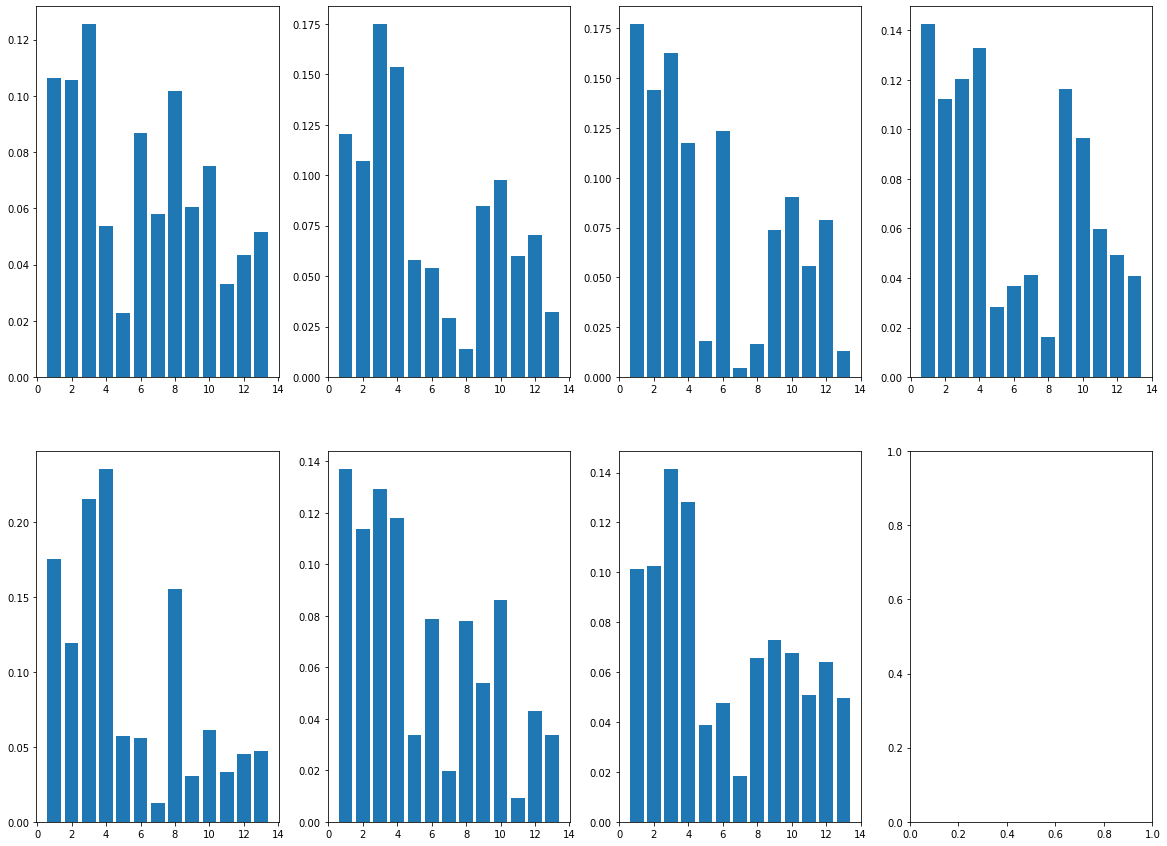

tensor(0.0789)


In [10]:
dice(model)